## Time Series Analysis and Forecasting
### Assignment 02

<AxesSubplot:>

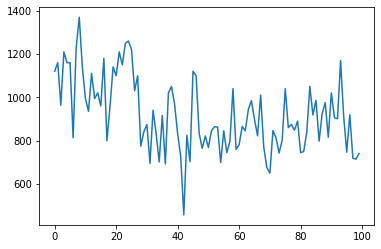

In [3]:
import statsmodels.api as sm

nile_df = sm.datasets.nile.load_pandas()
nile_df.data['volume'].plot()

In [4]:
nile_df.data.shape

(100, 2)